# Импорты

In [1]:
from os.path import join as pjoin
import os
import re
import tqdm

import pandas as pd
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from  torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt

# Содержание

- Файл simpson-set.tar.gz: Это набор данных изображений: 20 папок (по одной для каждого персонажа) с 400-2000 изображениями в каждой папке.
- Файл simpson-test-set.zip. : Предварительный просмотр набора данных изображения
- Файл weights.best.h5 : рассчитанные веса для прогнозирования в ядрах.
- Файл annotation.txt: файл аннотации для ограничивающих рамок для каждого символа.

# ----- Программа ------

# Констатанты

In [2]:
# папка откуда берем дата сет
SRC_FOLDER_DATA_SET = "data/simpsons_dataset/"
SRC_FOLDER_DATA_SET_TEST_IMAGE = "data/simpsons_dataset/sideshow_bob\pic_0167.jpg"

# параметры трансформа
MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]
SIZE_IMAGE = 96

# классы
CLASSES = ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 
           'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 
           'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 
           'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 
           'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 
           'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']

IS_SHOW_RESULT_TRAIN = 5
IS_SHOW_LOGS = False

In [3]:
# ===================== Конфигурация девайса
# поддержка графического процессора
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Гипер-параметры

In [4]:
EPOCHS = 15
LEARNING_RATE = 0.009
BATCH_SIZE = 128

# Изменение изображения

In [5]:
# ===================== Подготовка изображения
# Обработка входного изображения:
transform_image = transforms.Compose([
    transforms.Resize((SIZE_IMAGE, SIZE_IMAGE)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(MEAN_IMAGE_TRANSFORM),
                         torch.Tensor(MEAN_IMAGE_STD))
])


class LabelTransformer():
    def __init__(self, initial_list=CLASSES):
        self.initial_list = initial_list

    def __call__(self, val):
        if type(val) == str:
            return self.toInt(val)
        elif type(val) == int or type(val) == np.int64:
            return self.toStr(val)
        return None

    def toInt(self, label: str) -> int:
        return np.where(self.initial_list == label)[0][0]

    def toStr(self, ind: int) -> str:
        return self.initial_list[ind]


# Функции

In [6]:

# считать изображения для дата сета full
def get_full_data_set():
    full_dataset = torchvision.datasets.ImageFolder(
        root=SRC_FOLDER_DATA_SET, transform=transform_image)
    
    generator = torch.Generator().manual_seed(42)
    
    train_dataset, valid_dataset = torch.utils.data.random_split(
        full_dataset, [0.9, 0.1], generator=generator)

    classes_train = []
    for i, (images, labels) in enumerate(train_dataset):
        label = LabelTransformer()(labels)
        classes_train.append(label)

    classes_valid = []
    for i, (images, labels) in enumerate(valid_dataset):
        label = LabelTransformer()(labels)
        classes_valid.append(label)

    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    valid_dataloader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    return train_dataloader, valid_dataloader, classes_train, classes_valid

# отображение изображений
def print_result_sep_data(data, size):
    plt.figure(figsize=(10, 10))
    for index in range(size):
        plt.subplot(4, 4, index + 1)
        plt.tight_layout()
        # plt.imshow(data[index][0], cmap='gray', interpolation='none')
        plt.imshow(data[index][0])
    plt.show()

# получить веса для классов для кросэнтропии
def get_wight_classes(calasses):
    wight_clases = []
    uniq_classes = list(set(calasses))
    for i in range(len(uniq_classes)):
        wight_clases.append(calasses.count(uniq_classes[i]) / len(calasses))
    return wight_clases

# получить классы которые нужны
def get_onli_class_heve(keys, valyes, arrDeleteClasess):
    new_keys = []
    new_vals = []
    for i in zip(keys, valyes):
        add = True
        for deleteClass in arrDeleteClasess:
            if deleteClass == i[0]:
                add = False
        if add:
            new_keys.append(i[0])
            new_vals.append(i[1])
    return new_keys, new_vals


# Работа с дата сетом

In [7]:
train_data, test_data, classes_train, classes_test = get_full_data_set()
batch, _ = next(iter(train_data))


In [8]:
print(len(train_data))
print(len(set(classes_train)))

print(len(test_data))
print(len(set(classes_test)))
print(set(classes_test))


148
42
17
41
{'selma_bouvier', 'sideshow_mel', 'krusty_the_clown', 'abraham_grampa_simpson', 'agnes_skinner', 'ralph_wiggum', 'martin_prince', 'miss_hoover', 'professor_john_frink', 'gil', 'lisa_simpson', 'cletus_spuckler', 'principal_skinner', 'edna_krabappel', 'ned_flanders', 'troy_mcclure', 'groundskeeper_willie', 'lenny_leonard', 'carl_carlson', 'charles_montgomery_burns', 'bart_simpson', 'otto_mann', 'snake_jailbird', 'nelson_muntz', 'waylon_smithers', 'fat_tony', 'homer_simpson', 'moe_szyslak', 'marge_simpson', 'sideshow_bob', 'rainier_wolfcastle', 'chief_wiggum', 'barney_gumble', 'apu_nahasapeemapetilon', 'patty_bouvier', 'milhouse_van_houten', 'maggie_simpson', 'mayor_quimby', 'lionel_hutz', 'kent_brockman', 'comic_book_guy'}


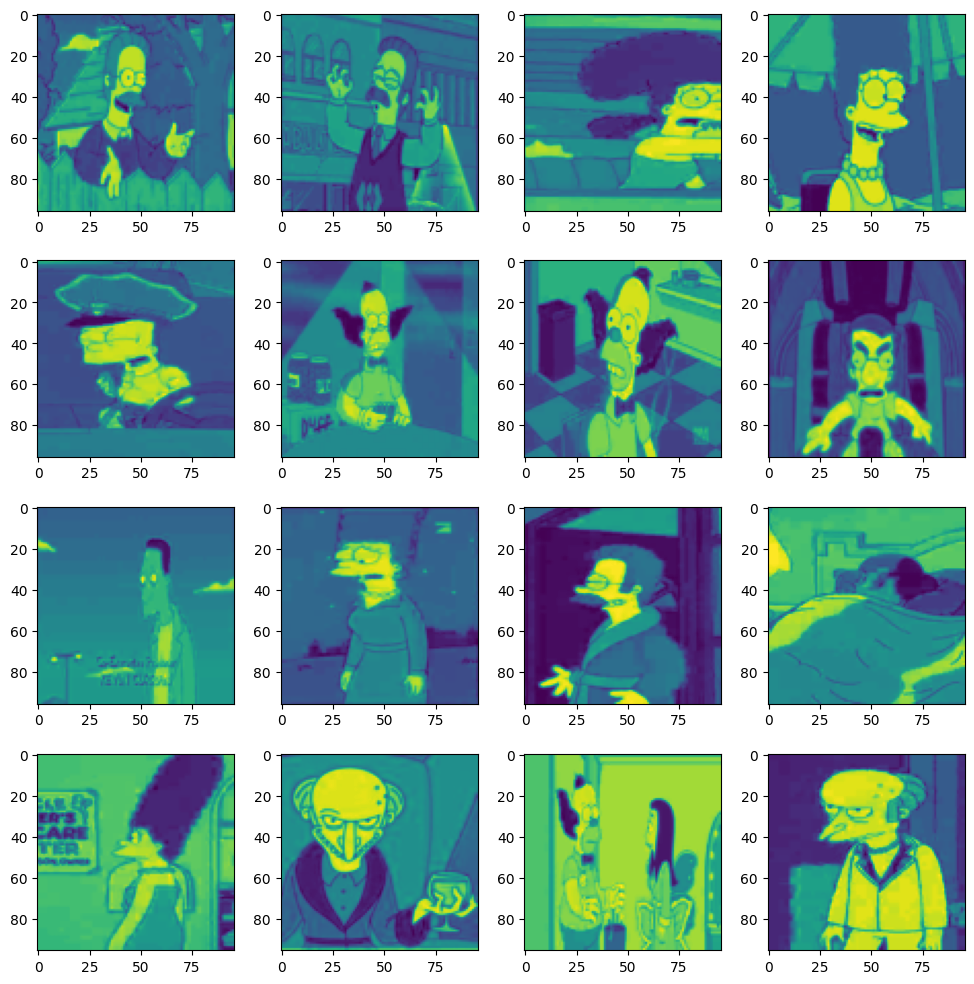

In [9]:
print_result_sep_data(batch, 16) # вывод картинок для себя

# Модель

In [10]:
class ConvNet(nn.Module):
    # в resNet часто встречается данная последовательность, поэтому решил ее вынести
    def conv_block(self, inC, outC, kernel_size, padding):
        return nn.Sequential(
            nn.Conv2d(inC, outC, kernel_size, padding=padding),
            nn.BatchNorm2d(outC),
            nn.ReLU(True),
        )

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            self.conv_block(3, SIZE_IMAGE, 3, 1),
            nn.MaxPool2d(4)
        )
        self.Bottleneck_1 = nn.Sequential(
            self.conv_block(SIZE_IMAGE, 32, 1, 0),
            self.conv_block(32, 32, 3, 1),
            self.conv_block(32, SIZE_IMAGE, 1, 0),
        )
        self.conv2 = nn.Sequential(
            self.conv_block(SIZE_IMAGE, 256, 3, 1),
            nn.MaxPool2d(2)
        )
        self.Bottleneck_2 = nn.Sequential(
            self.conv_block(256, 128, 1, 0),
            self.conv_block(128, 128, 3, 1),
            self.conv_block(128, 256, 1, 0),
        )
        self.conv3 = nn.Sequential(
            self.conv_block(256, 512, 3, 1),
            nn.MaxPool2d(2)
        )
        self.Bottleneck_3 = nn.Sequential(
            self.conv_block(512, 256, 1, 0),
            self.conv_block(256, 256, 3, 1),
            self.conv_block(256, 512, 1, 0),
        )
        self.conv4 = nn.Sequential(
            self.conv_block(512, 1024, 3, 1),
            nn.MaxPool2d(2)
        )
        self.res = nn.Sequential(
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.Linear(256, 128),
            nn.Linear(128, len(set(classes_train)))
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.Bottleneck_1(x) + x
        x = self.conv2(x)
        x = self.Bottleneck_2(x) + x
        x = self.conv3(x)
        x = self.Bottleneck_3(x) + x
        x = self.res(x)
        return x


# создали модель
model = ConvNet().to(device)

torch.save(model.state_dict(), 'model.pt')

torch.onnx.export(model, torch.ones((1,3,96,96)).to(device), 'MYmodel.onnx')

# print(model)
print(torchinfo.summary(model, input_size=(BATCH_SIZE, 3, SIZE_IMAGE, SIZE_IMAGE)))


Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [128, 42]                 4,721,664
├─Sequential: 1-1                        [128, 96, 24, 24]         --
│    └─Sequential: 2-1                   [128, 96, 96, 96]         --
│    │    └─Conv2d: 3-1                  [128, 96, 96, 96]         2,688
│    │    └─BatchNorm2d: 3-2             [128, 96, 96, 96]         192
│    │    └─ReLU: 3-3                    [128, 96, 96, 96]         --
│    └─MaxPool2d: 2-2                    [128, 96, 24, 24]         --
├─Sequential: 1-2                        [128, 96, 24, 24]         --
│    └─Sequential: 2-3                   [128, 32, 24, 24]         --
│    │    └─Conv2d: 3-4                  [128, 32, 24, 24]         3,104
│    │    └─BatchNorm2d: 3-5             [128, 32, 24, 24]         64
│    │    └─ReLU: 3-6                    [128, 32, 24, 24]         --
│    └─Sequential: 2-4                   [128, 32, 24, 24]         --
│

# Обучение

In [11]:
weight=torch.FloatTensor(get_wight_classes(classes_train))
# создали потери (кроссэнтропия так как у нас много классовая классификация) тут же и совт макс
criterion = nn.CrossEntropyLoss(weight=weight.to(device))
# создали оптимизатор стахастический градиентный спуск - получаем скорость обучения
optimizer = torch.optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=0.9)
# scheduler = ReduceLROnPlateau(optimizer, 'min')

len_steps = len(train_data)
list_loos = []
# обучение
for epoch in range(EPOCHS):
    list_loos_epoch = []
    # перегрузчик, что бы получить разные партии
    for i, (images, labels) in enumerate(train_data):
        # получаем поддержку графического процессора
        images = images.to(device)
        labels = labels.to(device)
        # проходим вперед
        outputs = model(images)
        # создаем потери
        loss = criterion(outputs, labels)
        list_loos_epoch.append(loss.item())
        # чистка градиента
        optimizer.zero_grad()
        # обратный проход
        loss.backward()
        # оптимизируем шаг
        optimizer.step()
        print(
            f'Epoch [{epoch+1}/{EPOCHS}], step [{i+1}/{len_steps}], loss {loss.item():.4f}')
    # scheduler.step(loss, epoch) # lr <
    list_loos.append(sum(list_loos_epoch) / float(len(list_loos_epoch)))
print("finish")


Epoch [1/15], step [1/148], loss 3.8671
Epoch [1/15], step [2/148], loss 2.9340
Epoch [1/15], step [3/148], loss 3.3140
Epoch [1/15], step [4/148], loss 3.7302
Epoch [1/15], step [5/148], loss 3.8724
Epoch [1/15], step [6/148], loss 4.7833
Epoch [1/15], step [7/148], loss 3.7307
Epoch [1/15], step [8/148], loss 3.4916
Epoch [1/15], step [9/148], loss 3.4795
Epoch [1/15], step [10/148], loss 3.4487
Epoch [1/15], step [11/148], loss 3.1346
Epoch [1/15], step [12/148], loss 2.7904
Epoch [1/15], step [13/148], loss 2.6044
Epoch [1/15], step [14/148], loss 2.3935
Epoch [1/15], step [15/148], loss 2.5277
Epoch [1/15], step [16/148], loss 2.7556
Epoch [1/15], step [17/148], loss 3.0398
Epoch [1/15], step [18/148], loss 2.7366
Epoch [1/15], step [19/148], loss 3.3969
Epoch [1/15], step [20/148], loss 2.3908
Epoch [1/15], step [21/148], loss 2.0011
Epoch [1/15], step [22/148], loss 2.7513
Epoch [1/15], step [23/148], loss 2.4387
Epoch [1/15], step [24/148], loss 2.2882
Epoch [1/15], step [25/14

KeyboardInterrupt: 

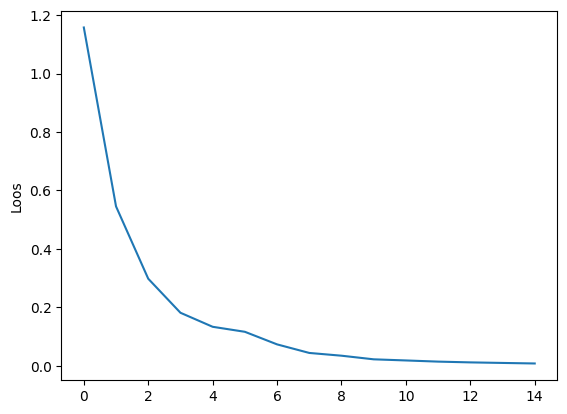

In [ ]:
plt.plot([i for i in range(0, EPOCHS)], list_loos)
plt.ylabel('Loos')
plt.show()

# Проверка точности

In [ ]:
classes = CLASSES  # set(classes_test)
classes_amount = len(classes)
сlass_list_result = list(set(classes_test))
classes_test_set = list(set(classes)-set(classes_test))
classes_amount_test_set = len(set(classes_test))

recall = MulticlassRecall(num_classes=classes_amount, average=None)
precision = MulticlassPrecision(num_classes=classes_amount, average=None)
recall.to(device)
precision.to(device)

with torch.no_grad():
    model.eval()
    for images, labels in test_data:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        recall.update(outputs, labels)
        precision.update(outputs, labels)

recall_class = {сlass_list_result: val.item()
                for сlass_list_result, val in zip(classes, recall.compute())}
precision_class = {сlass_list_result: val.item()
                   for сlass_list_result, val in zip(classes, precision.compute())}

total_rec = sum(recall.compute())/classes_amount_test_set
total_prec = sum(precision.compute())/classes_amount_test_set


# График Метрик

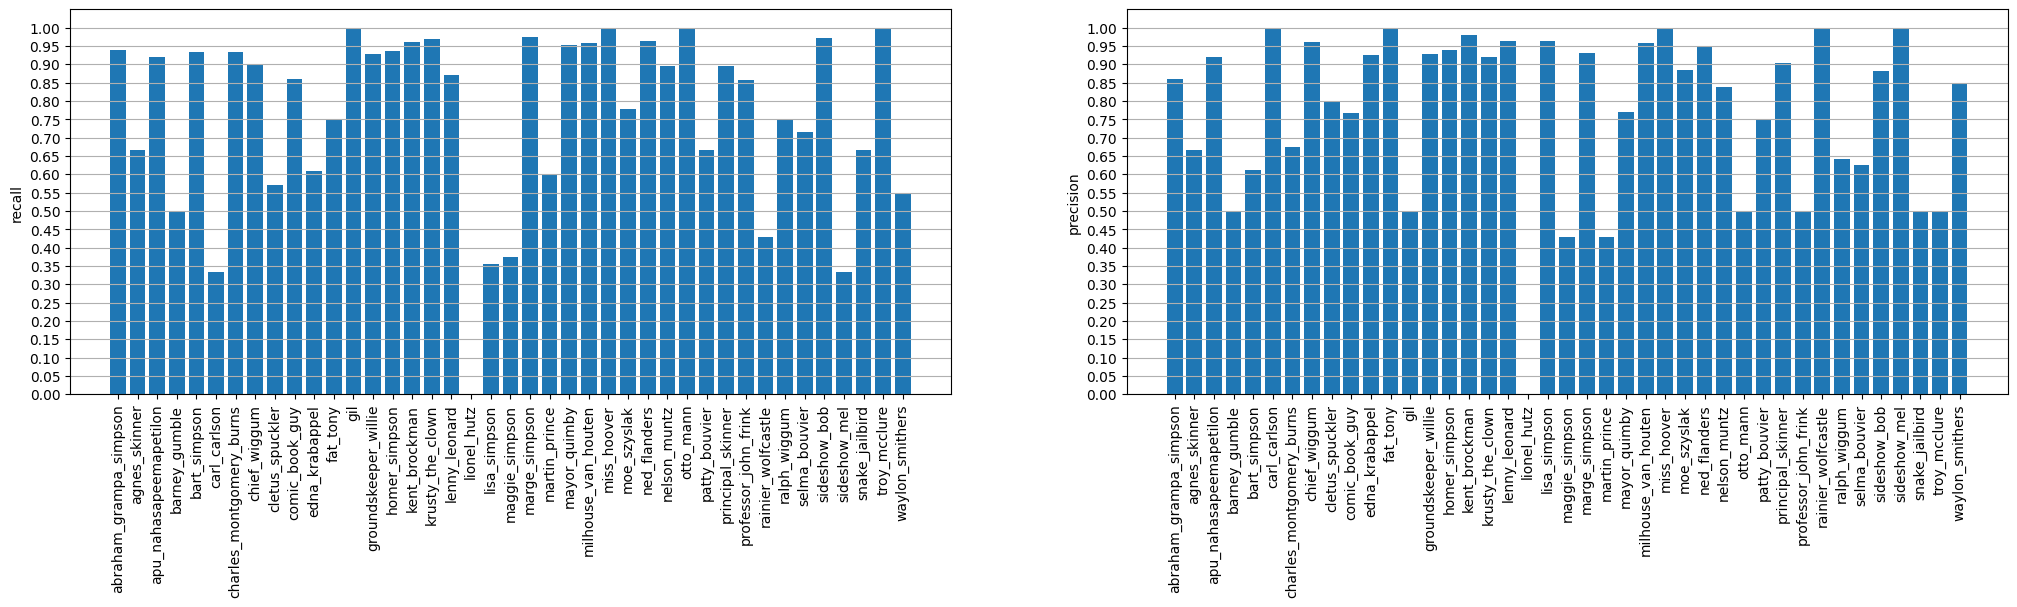

 total_rec: 0.76%
 total_prec: 0.77% 
 F1: 76.8149%


In [ ]:
metrics_per_class = {
    "recall": recall_class, "precision": precision_class}

fig, axes = plt.subplots(1, 2, figsize=(25, 5))
for (metricName, mVal), ax in zip(metrics_per_class.items(), axes):
    keys, values = get_onli_class_heve(
        mVal.keys(), mVal.values(), classes_test_set)
    plt.sca(ax)
    plt.bar(keys, values)
    plt.ylabel(metricName)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.yticks(ticks=np.arange(0, 1.01, 0.05))
plt.show()

rec = sum(recall.compute())
prec = sum(precision.compute())
f1 = 2 * ((total_rec*total_prec)/(total_rec+total_prec))*100

print(
    f' total_rec: {total_rec:.2f}%\n total_prec: {total_prec:.2f}% \n F1: {f1:.4f}%')


# Доп. проверка
тут есть проверка на дата сет не из сайта с заданием. 
Данный дата сет предоставил одногрупник для дополнительной проверки модели

In [ ]:
class LabelTransformer():
    def __init__(self, initial_list=CLASSES):
        self.initial_list = np.array(initial_list)

    def __call__(self, val):
        if type(val) == str:
            return self.toInt(val)
        elif type(val) == int or type(val) == np.int64:
            return self.toStr(val)
        return None

    def toInt(self, label: str) -> int:
        return np.where(self.initial_list == label)[0][0]

    def toStr(self, ind: int) -> str:
        return self.initial_list[ind]

MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]
SIZE_IMAGE = 96

transform = torchvision.transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((SIZE_IMAGE,SIZE_IMAGE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN_IMAGE_TRANSFORM, MEAN_IMAGE_STD),
])


class SimpsonsTestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None, label_transform=None):
        self.files = []
        for r, dir, files in os.walk(img_dir):
            self.files += files
        self.calculateClasses()
        self.img_dir = img_dir
        self.transform = transform
        self.label_transform = label_transform

    def extractName(self, s):
        se = re.search(r"[a-zA-Z_]+[^\d]?", s)
        return se.group(0)[:-1]

    def calculateClasses(self):
        self.s = set()
        for i in self.files:
            self.s.add(self.extractName(i))
        return list(self.s)

    @property
    def classes(self):
        return list(self.s)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = pjoin(self.img_dir, self.files[index])
        image = torchvision.io.read_image(img_path)
        label = self.extractName(self.files[index])

        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label
    
    
test_dataset = SimpsonsTestDataset(
    "data/newSet", transform=transform, label_transform=LabelTransformer())

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)


def test_metrics_per_class(model, testloader, dataset=None):
    classes = CLASSES
    classes_amount = len(CLASSES)
    stats = MulticlassAccuracy(num_classes=classes_amount, average=None)
    stats.to(device)

    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            stats.update(outputs, labels)

    tp, fp, tn, fn = stats._final_state()
    def saveDivide(x, y): return torch.nan_to_num(x/y)

    accuracy = saveDivide((tp+tn), (tp+fp+tn+fn))
    recall = saveDivide(tp, (tp+fn))
    precision = saveDivide(tp, (tp+fp))
    accuracy_per_class = {classname: val.item()
                          for classname, val in zip(classes, accuracy)}
    recall_per_class = {classname: val.item()
                        for classname, val in zip(classes, recall)}
    precision_per_class = {classname: val.item()
                           for classname, val in zip(classes, precision)}
    try:
        classes_amount_correct = len(dataset.classes)
        classes_correct = dataset.classes
        print("Recalculate metrics with correct dataset classes")

        def slice_dict(dict, sliceBy): return {
            k: dict[k] for k in dict if k in sliceBy}
        accuracy_per_class = slice_dict(accuracy_per_class, classes_correct)
        recall_per_class = slice_dict(recall_per_class, classes_correct)
        precision_per_class = slice_dict(precision_per_class, classes_correct)

        total_rec = sum(recall)/classes_amount_correct
        total_prec = sum(precision)/classes_amount_correct
    except:
        total_rec = sum(recall)/classes_amount
        total_prec = sum(precision)/classes_amount
    total_acc = sum(accuracy)/classes_amount
    return {"accuracy": accuracy_per_class, "recall": recall_per_class, "precision": precision_per_class}, {"accuracy": total_acc, "recall": total_rec, "precision": total_prec}


metrics_per_class, metrics_total = test_metrics_per_class(
    model, test_dataloader, test_dataset)
print(metrics_per_class)


Recalculate metrics with correct dataset classes
{'accuracy': {'abraham_grampa_simpson': 0.984000027179718, 'agnes_skinner': 0.9919999837875366, 'apu_nahasapeemapetilon': 0.984000027179718, 'barney_gumble': 0.984000027179718, 'bart_simpson': 0.984000027179718, 'carl_carlson': 0.984000027179718, 'charles_montgomery_burns': 0.9440000057220459, 'chief_wiggum': 0.9919999837875366, 'cletus_spuckler': 0.9919999837875366, 'comic_book_guy': 0.9520000219345093, 'disco_stu': 0.9760000109672546, 'edna_krabappel': 0.9919999837875366, 'fat_tony': 0.984000027179718, 'gil': 0.9919999837875366, 'groundskeeper_willie': 0.9919999837875366, 'homer_simpson': 0.984000027179718, 'kent_brockman': 0.9919999837875366, 'krusty_the_clown': 0.9919999837875366, 'lenny_leonard': 0.9919999837875366, 'lionel_hutz': 0.9919999837875366, 'lisa_simpson': 0.984000027179718, 'maggie_simpson': 1.0, 'marge_simpson': 1.0, 'martin_prince': 0.9760000109672546, 'mayor_quimby': 0.984000027179718, 'milhouse_van_houten': 1.0, 'miss

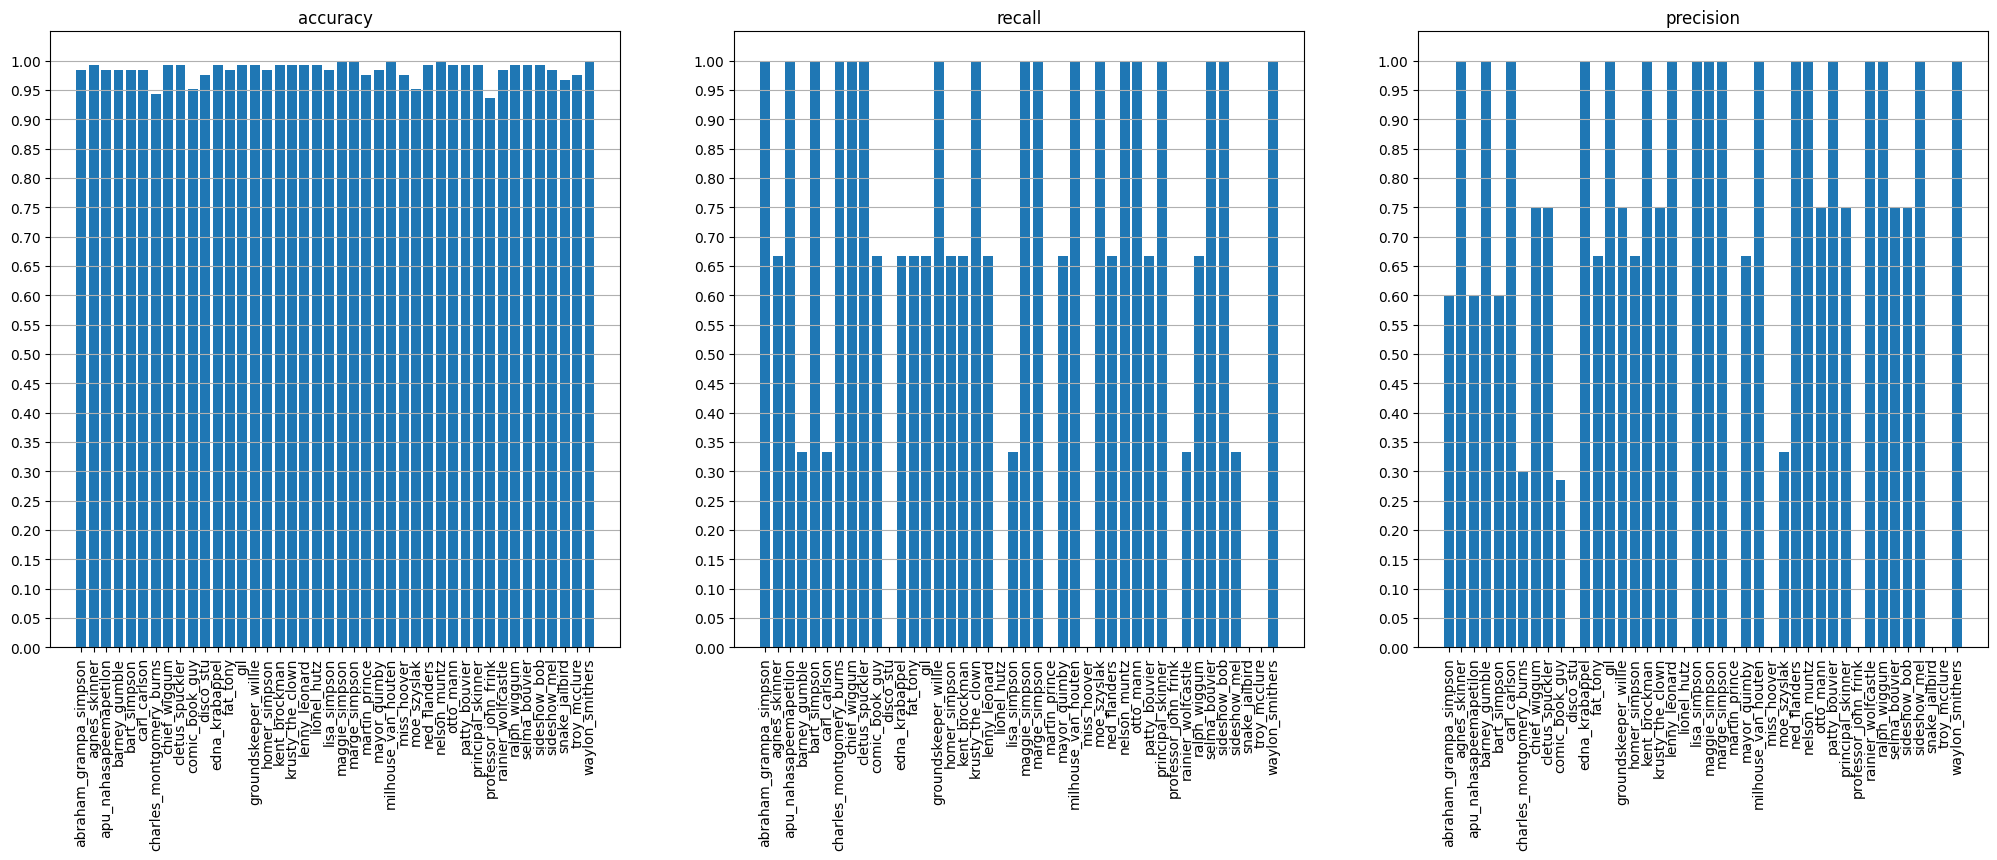



Test:
accuracy: 98.4381%
recall: 65.8730%
precision: 68.3787%
F: 67.1025%


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,8))

for (metricName, mVal), ax in zip(metrics_per_class.items(), axes):
    plt.sca(ax)
    plt.bar(mVal.keys(), mVal.values())
    plt.title(metricName)
    plt.grid(axis='y')
    plt.xticks(rotation=90)
    plt.yticks(ticks=np.arange(0, 1.01, 0.05))
plt.show()

result = f"""\n\nTest:
accuracy: {metrics_total['accuracy']*100:.4f}%
recall: {metrics_total['recall']*100:.4f}%
precision: {metrics_total['precision']*100:.4f}%
F: {2 * metrics_total['precision']*metrics_total['recall']/(metrics_total['precision']+metrics_total['recall'])*100:.4f}%"""

print(result)

# Мои наработки разные в общем мусор

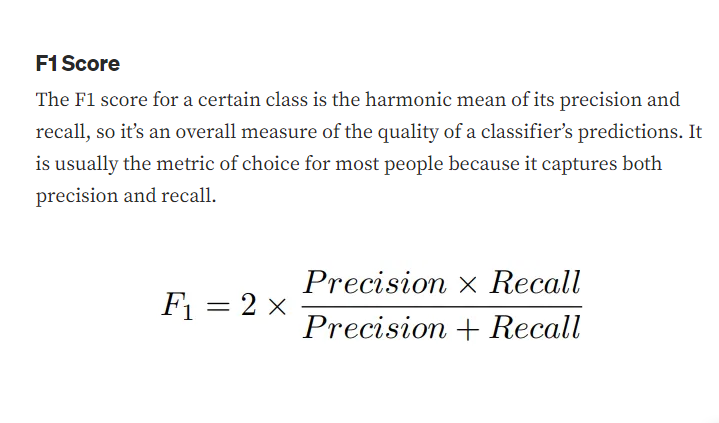

In [ ]:

# accur = (tp+tn)/(tp+tn+fp+fn)
# total_accur = sum(accur)/classes_amount

# Они смягчают проблему исчезновения градиента, позволяя этому альтернативному короткому пути проходить градиент
# Они позволяют модели изучать функцию идентичности, которая гарантирует, что верхний уровень будет работать по меньшей мере так же хорошо, как и нижний, и не хуже

# # вычисление точности всей сети
# list_acc = []

# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     n_class__correct = [0 for i in range(len(CLASSES))]
#     n_class__samples = [0 for i in range(len(CLASSES))]

#     for images, labels in test_data:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)

#         # максимальное значение индекс
#         _, predicted = torch.max(outputs, 1)
#         n_samples += labels.size(0)
#         n_correct += (predicted == labels).sum().item()

#         for i in range(len(labels)):
#             label = labels[i]
#             pred = predicted[i]
#             if (label == pred):
#                 n_class__correct[label] += 1
#             n_class__samples[label] += 1

#     acc = 100 * n_correct / n_samples
#     print(f'Accuracy of the network {acc} %\n\n')

#     # вычисление точности для классов
#     for i in range(len(CLASSES)):
#         if (n_class__correct[i] != 0):
#             acc = 100 * n_class__correct[i] / n_class__samples[i]
#             print(f'Accuracy of {CLASSES[i]} {acc} %')
#         else:
#             acc = 0
#             print(f'Accuracy of {CLASSES[i]} {acc} %')
#         list_acc.append(acc)


In [ ]:
# fig = plt.figure(figsize=(16, 8))

# plt.bar(CLASSES, list_acc)
# plt.grid()
# plt.xticks(rotation=45, ha='right')
# plt.show()

In [ ]:
    #     self.conv1 = nn.Sequential(
    #         nn.Conv2d(3, 64, 5),
    #         nn.BatchNorm2d(64),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.conv2 = nn.Sequential(
    #         nn.Conv2d(64, 32, 5),
    #         nn.BatchNorm2d(32),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.conv3 = nn.Sequential(
    #         nn.Conv2d(32, 16, 5),
    #         nn.BatchNorm2d(16),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.fc1 = nn.Linear(start_size_conv, 512)
    #     self.fc2 = nn.Linear(512, 128)
    #     self.fc3 = nn.Linear(128, 64)
    #     self.fc4 = nn.Linear(64, len(CLASSES))
        
    # def forward(self, x: torch.Tensor):
    #     x = self.conv1(x)
    #     x = self.conv2(x)
    #     x = self.conv3(x)
        
    #     x = x.view(-1, start_size_conv) # сплющели
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = F.relu(self.fc3(x))
    #     x = self.fc4(x)
    #     return x
    
    # 50 gпроцентов без 3го, за 10 итераций, за 10 с двумя